In [27]:
import os
import numpy as np
from scipy.io import loadmat
import h5py
from preproc import *
from priordist import PriorDistributionCell

In [28]:
# Specify which day's dataset to use
prefix = "/Volumes/Hippocampus/Data/picasso-misc/"
day_dir = "20181102"

In [29]:
# Get list of cells under the day directory
os.system(f"sh ~/Documents/neural_decoding/scripts/get_cells.sh {day_dir}")
cell_list = list()
with open("cell_list.txt", "r") as file:
    for line in file.readlines():
        cell_list.append(line.strip())
os.system("rm cell_list.txt")

# Load data from rplparallel.mat object, extract trial markers, time stamps and session start timestamp
rp = h5py.File(prefix + day_dir + "/session01/rplparallel.mat")
rp = rp.get('rp').get('data')
trial_markers = np.array(rp.get('markers'))
trial_timestamps = np.array(rp.get('timeStamps'))
session_start_time = np.round(np.array(rp.get('session_start_sec'))[0,0], 3)

# Load data and extract spike times from all spiketrain.mat objects
spike_times = list()
cell_labels = list()
for cell_dir in cell_list:
    spk = loadmat(prefix + day_dir + "/session01/" + cell_dir + "/spiketrain.mat")
    spk = spk.get('timestamps').flatten() # spike timestamps is loaded in as a column vector
    spk = spk / 1000 # convert spike timestamps from msec to sec
    spike_times.append(spk)
    
    cell_name = cell_dir.split('/')
    array, channel, cell = cell_name[0][6:], cell_name[1][7:], cell_name[2][5:]
    if channel[0] == '0':
        channel = channel[1:]
    cell_labels.append(f'a{array}/ch{channel}/c{cell}')

# Load data from vmpv.mat object, extract session end timestamp
pv = h5py.File(prefix + day_dir + "/session01/1vmpv.mat")
pv = pv.get('pv').get('data')
session_end_time = np.round(np.array(pv.get('rplmaxtime'))[0,0], 3)

1 second time bins

In [30]:
# Get poster numbers from trial markers, cue phase time intervals
trial_markers = trial_markers[0,:] % 10
trial_markers = trial_markers.astype(int)
cue_intervals = trial_timestamps[0:2,:].T

# Generate time intervals for navigation phases and bin into 1-second time bins
nav_timestamps = trial_timestamps[1:,:].T
nav_intervals = list()
delta = 1  # Size of time bin (in seconds)
for idx, intvl in enumerate(nav_timestamps):
    nav_start, nav_end = intvl
    nav_intervals.append(np.vstack((np.arange(nav_start, nav_end - delta, delta), np.arange(nav_start + delta, nav_end, delta))).T)

# Generate time intervals for each trial
trial_intervals = np.empty_like(cue_intervals)
trial_intervals[:,0] = cue_intervals[:,1]
trial_intervals[:-1,1] = cue_intervals[1:,0]
trial_intervals[-1,1] = session_end_time


In [31]:
# Check number of time bins per trial
timebins_per_nav_phase = np.array(list(map(lambda arr: arr.shape[0], nav_intervals)))

# Filter out trials that are too long (> 25 seconds) or have repeated goal from previous trial
good_trials = np.ones(timebins_per_nav_phase.shape, dtype=np.int8)
max_dur = 25  # maximum duration of trials (in seconds) to filter out
prev_goal = 0
for num, dur in enumerate(timebins_per_nav_phase):
    curr_goal = trial_markers[num]
    if dur > max_dur or curr_goal == prev_goal:
        good_trials[num] = 0
    prev_goal = curr_goal
trial_filt = np.where(good_trials == 1)

trial_markers = trial_markers[trial_filt]
cue_intervals = cue_intervals[trial_filt,:][0]  # not sure why it adds an extra axis
new_nav_intervals = list()
for num, trial in enumerate(nav_intervals):
    if good_trials[num] == 1:
        new_nav_intervals.append(trial)
nav_intervals = new_nav_intervals
timebins_per_nav_phase = timebins_per_nav_phase[trial_filt]
trial_intervals = trial_intervals[trial_filt]

In [32]:
# Bin entire session into 1-second time bins, aligned to the end of each cue phase for each trial
session_intervals = list()
for idx, intvl in enumerate(trial_intervals):
    session_intervals.append(cue_intervals[idx,:])
    nav_start, nav_end = intvl
    for time in np.arange(nav_start, nav_end - 1, 1):
        session_intervals.append(np.array([time, time + 1]))
session_intervals = np.array(session_intervals)

# Slot spikes into cue phase intervals for each trial
spikecounts_per_trial = spike_counts_per_observation(cue_intervals, spike_times)

# Slot spikes into session time intervals
spikecounts_across_session = spike_counts_per_observation(session_intervals, spike_times)

In [33]:
# Get outcomes of each trial
trial_outcomes = np.array(rp.get('markers'))
trial_outcomes = trial_outcomes[2,:] // 10
trial_outcomes = trial_outcomes.astype(int)
trial_outcomes = trial_outcomes[trial_filt]

# Filter out successful trials only
successful_trials = np.where(trial_outcomes == 3)
trial_markers_success = trial_markers[successful_trials]
spikecounts_per_trial_success = spikecounts_per_trial[successful_trials,:][0] # Need to flatten the result somehow

In [34]:
# Bin spike counts within each cell for entire sesion, and get firing rate thresholds used for binning
binned_spikes_across_session = np.empty_like(spikecounts_across_session)
binning_stats = list()
for col in range(spikecounts_across_session.shape[1]):
    binned_spikes_across_session[:,col] = bin_firing_rates_4(spikecounts_across_session[:,col])
    binning_stats.append(get_binning_stats_4(spikecounts_across_session[:,col]))

# Bin spike counts within each cell for cue phases
binned_spikes_per_trial = np.empty_like(spikecounts_per_trial)
for col in range(spikecounts_per_trial.shape[1]):
    binned_spikes_per_trial[:,col] = bin_firing_rates_4(spikecounts_per_trial[:,col], stats=binning_stats[col])

# Bin spike counts within each cell for cue phases of successful trials
binned_spikes_per_trial_success = np.empty_like(spikecounts_per_trial_success)
for col in range(spikecounts_per_trial_success.shape[1]):
    binned_spikes_per_trial_success[:,col] = bin_firing_rates_4(spikecounts_per_trial_success[:,col], stats=binning_stats[col])

In [35]:
def group_by_goal(timeseries: np.array, goals: np.array) -> list:
    num_goals = 6
    grouped = [np.empty((0, timeseries.shape[1])) for _ in range(num_goals)]
    for idx, goal in enumerate(goals):
        goal = int(goal - 1)
        grouped[goal] = np.vstack((grouped[goal], timeseries[idx,:]))
    return grouped

In [36]:
# Group cue phase spikes according to goal
responses_per_goal = group_by_goal(binned_spikes_per_trial, trial_markers)

# Get distribution of population responses across entire session
response_distribution_session = PriorDistributionCell(binned_spikes_across_session, responses_per_goal)

In [37]:
# Group cue phase spikes according to goal for successful trials
responses_per_goal_success = group_by_goal(binned_spikes_per_trial_success, trial_markers_success)

# Get distribution of population responses across entire session for successful trials
response_distribution_session_success = PriorDistributionCell(binned_spikes_across_session, responses_per_goal_success)

In [38]:
# Some important constants
num_goals = 6
num_cells = len(cell_list)
num_cats = 4

In [39]:
# Shannon entropy across goals
goal_entropy = 0
for goal in range(num_goals):
    P_s = response_distribution_session.P_s(goal)
    goal_entropy -= P_s * np.log2(P_s)

print(goal_entropy)

2.573664397104504


In [40]:
np.log2(6)

2.584962500721156

In [41]:
# Unconditioned entropy of responses across entire session
session_entropy = np.zeros(num_cells)
for cell in range(num_cells):
    for cat in range(num_cats):
        P_r = response_distribution_session.P_r(cell, cat)
        if P_r != 0:
            session_entropy[cell] -= P_r * np.log2(P_r)

# for obs in binned_spikes_across_session:
#     for cell, resp in enumerate(obs):
#         resp = int(resp)
#         P_r = response_distribution_session.P_r(cell, resp)
#         session_entropy[cell] -= P_r * np.log2(P_r)

print(session_entropy)

[0.99127766 1.88795808 0.         0.         0.95761572 1.95628366
 1.9454631  1.94812457 1.97619505 1.54023679 1.98681324 0.
 0.        ]


In [42]:
# Conditioned entropy of responses per goal
goal_response_entropy = np.zeros((num_goals, num_cells))
for goal in range(num_goals):
    for cell in range(num_cells):
        for cat in range(num_cats):
            P_r_s = response_distribution_session.P_r_s(cell, cat, goal)
            if P_r_s != 0:
                goal_response_entropy[goal, cell] -= P_r_s * np.log2(P_r_s)

# for goal, responses in enumerate(responses_per_goal):
#     for obs in responses:
#         for cell, resp in enumerate(obs):
#             resp = int(resp)
#             P_r_s = response_distribution_session.P_r_s(cell, resp, goal)
#             goal_response_entropy[goal, cell] -= P_r_s * np.log2(P_r_s)

In [43]:
# Information gain per stimulus (relative to entire session responses)
information_gain = np.zeros((num_goals, num_cells))

for goal in range(num_goals):
    for cell in range(num_cells):
        for cat in range(num_cats):
            P_r_s = response_distribution_session.P_r_s(cell, cat, goal)
            P_r = response_distribution_session.P_r(cell, cat)
            if P_r_s != 0:
                information_gain[goal, cell] += P_r_s * np.log2(P_r_s / P_r)

# for goal, responses in enumerate(responses_per_goal):
#     for obs in responses:
#         for cell, resp in enumerate(obs):
#             resp = int(resp)
#             P_r_s = response_distribution_session.P_r_s(cell, resp, goal)
#             P_r = response_distribution_session.P_r(cell, resp)
#             information_gain[goal, cell] += P_r_s * np.log2(P_r_s / P_r)

In [44]:
# Information gain per stimulus for successful trials only
information_gain_success = np.zeros((num_goals, num_cells))

for goal in range(num_goals):
    for cell in range(num_cells):
        for cat in range(num_cats):
            P_r_s = response_distribution_session_success.P_r_s(cell, cat, goal)
            P_r = response_distribution_session_success.P_r(cell, cat)
            if P_r_s != 0:
                information_gain_success[goal, cell] += P_r_s * np.log2(P_r_s / P_r)

In [45]:
# Net information gain acrosss entire stimuli set
net_information_gain = np.zeros(num_cells)
for cell in range(num_cells):
    for goal in range(num_goals):
        I_s_R = information_gain[goal, cell]
        P_s = response_distribution_session.P_s(goal)
        net_information_gain[cell] += P_s * I_s_R

print(net_information_gain)

[0.00776766 0.13831873 0.         0.         0.33063682 0.23866298
 0.05217741 0.05109419 0.06451824 0.07499016 0.22138719 0.
 0.        ]


In [46]:
# Net information gain across entire stimuli set for successful trials only
net_information_gain_success = np.zeros(num_cells)
for cell in range(num_cells):
    for goal in range(num_goals):
        I_s_R = information_gain_success[goal, cell]
        P_s = response_distribution_session_success.P_s(goal)
        net_information_gain_success[cell] += P_s * I_s_R

print(net_information_gain_success)

[0.00783103 0.1484604  0.         0.         0.31986458 0.23686423
 0.05627215 0.05587739 0.06245568 0.0780786  0.22960077 0.
 0.        ]


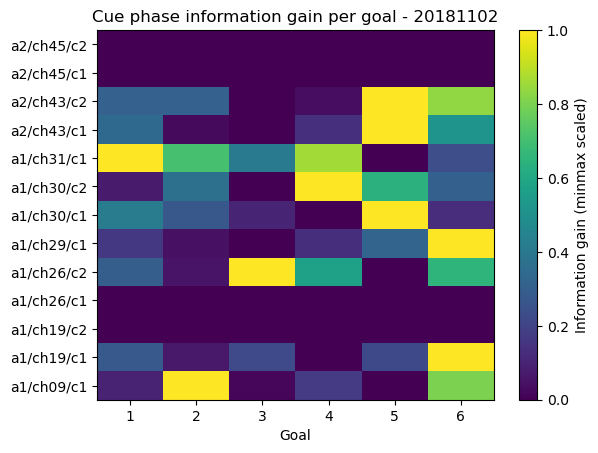

In [55]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale

information_gain = information_gain.T
information_gain_scaled = np.empty_like(information_gain)
for idx, row in enumerate(information_gain):
    information_gain_scaled[idx,:] = minmax_scale(row)

plt.figure()
plt.title(f'Cue phase information gain per goal - {day_dir}')
plt.pcolormesh(information_gain_scaled)
plt.colorbar(label='Information gain (minmax scaled)')
plt.xlabel('Goal')
plt.xticks(np.arange(0.5, num_goals+0.5), labels=np.arange(1, num_goals+1))
plt.yticks(np.arange(0.5, num_cells+0.5), labels=cell_labels)
plt.show()

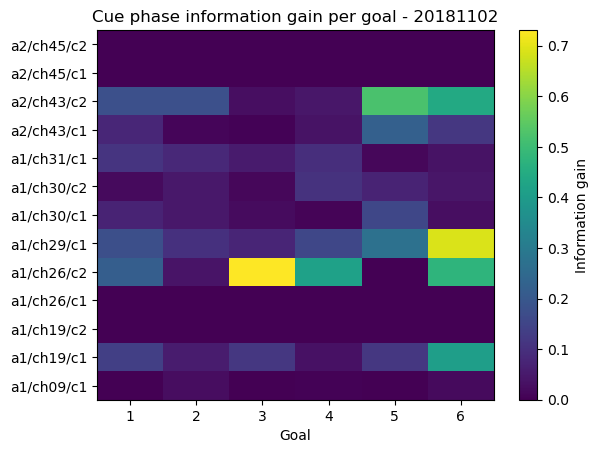

In [48]:
plt.figure()
plt.title(f'Cue phase information gain per goal - {day_dir}')
plt.pcolormesh(information_gain)
plt.colorbar(label='Information gain')
plt.xlabel('Goal')
plt.xticks(np.arange(0.5, num_goals+0.5), labels=np.arange(1, num_goals+1))
plt.yticks(np.arange(0.5, num_cells+0.5), labels=cell_labels)
plt.show()